# Spectral Methods

## Case 1
Consider the following PDE with constant $a$:
$$\frac{\partial u}{\partial t} = a\frac{\partial u}{\partial x}.$$




Represent the solution $u(x,t)$ as
$$u(x,t) = \sum_n \hat{u}_n(t)\phi_n(x),$$
where $\phi_n$ are some basis functions and $\hat{u}_n$ are corresponding weighting factors.

In a spectral method we take $\phi_n$ as $e^{2\pi inx/L}=\cos(2\pi nx/L)+i\sin(2\pi nx/L)$, where $i$ is the imaginary number and $L$ is the domain size.
- Note that $re^{i\theta} = r\cos(\theta) + ir\sin(\theta)$ so that polar coordinates $r,\,\theta$ in the complex plane map to Cartesian components $x=r\cos(\theta)$ and $y=r\sin(\theta)$.

<img src="https://ignite.byu.edu/che541/lectures/figs/spectral/complex_angle.png" width=500>



Here, $\phi_n$ are periodic functions and we assume periodic boundary conditions.

This gives $u$ as a discrete inverse Fourier transform, and we take a (truncated) summation from $n=-N/2+1$ to $n=N/2$.

This results in 
<font color=green>
$$u = \sum_{n=-N/2+1}^{N/2} \hat{u}_n e^{2\pi inx/L}.$$
</font>

In particular, consider a grid of N points with uniform spacing $\Delta x$. If the points are indexed by $j$, starting at $j=0$, we have $\Delta x=L/N$, and $x_j=j\Delta x=jL/N$. Let $u_j\equiv u(x_j)$. 

<img src=https://ignite.byu.edu/che541/lectures/figs/spectral/grid.png width=500>



The exponent of $e$ in the IDFT (and DFT) is an angle in the complex plane, and the multiplicative factor $n$ in the exponent effectively steps the angle around the circle in the complex plane. The figure below illustrates this for an even and an odd number of points.

<img src=https://ignite.byu.edu/che541/lectures/figs/spectral/circles.png width=500>

The vertical dashed lines connect points with conjugate symmetry (the imaginary parts are the same in magnitude but have opposite signs). If $u$ is real, then $\hat{u}$ will have conjugate symmetry so that the IDFT of $\hat{u}$ will give cancellation of the imaginary parts, yielding the real-valued $u$.

For numerical solution, it is important that the ordering of the indicies $n$ match the ordering provided by the fast Fourier transform (and its corresponding inverse). 

This is illustrated below in Python for five points. This shows that the points are ordered starting at $n=0$ and traversing counter-clockwise:
$$n=0,\,1,\,2,\,-2,\,-1.$$
For general $N$, we can write (Python)
```julia
n = collect(0:N-1)
n[Int64(floor(N/2))+2:end] .-= N
```

In [1]:
using Plots
using FFTW
using Random
using DifferentialEquations
using PyFormattedStrings
using LinearAlgebra
using QuadGK
using CurveFit            # poly_fit function
using Polynomials         # Polynomial function

In [2]:
u = rand(5)
uhat = fft(u)
for i in uhat
    println(f"{real(i):.4f} + {imag(i):.4f}j")
end

2.9605 + 0.0000j
0.6160 + -0.7021j
-0.1430 + 0.0555j
-0.1430 + -0.0555j
0.6160 + 0.7021j


The inverse discrete Fouier transform (IDFT) of $\hat{u}_n$ evaluated at grid points $x_j$ and denoted $F^{-1}$, is given by
$$u_j = F^{-1}(\hat{u}_n):\phantom{xx} u_j = \sum_{n=-N/2+1}^{N/2} \hat{u}_n e^{2\pi inj/N},\;\;\;j=0,\ldots,N-1.$$
The corresponding discrete Fourier transform (DFT) is given by
$$\hat{u}_n=F(u_j):\phantom{xx} \hat{u}_n = \frac{1}{N}\sum_{j=0}^{N-1} u_j e^{-2\pi inj/N},\;\;\;n=-\frac{N}{2}+1,\ldots,\frac{N}{2}.$$

These are evaluated using packaged fast Fourier transform (FFT) routines (and the corresponding fast inverse).

<img src="https://ignite.byu.edu/che541/lectures/figs/spectral/physical_spectral.png" width=300>

Now we will insert the green equation into the PDE. Note that $\hat{u}$ is not a function of position, and $d e^{2\pi inx/L}/d x=(2\pi in/L)e^{2\pi inx/L}.$ Furthermore, the summation commutes with differentiation. The result, omitting the bounds of the summation is
$$\sum_n e^{2\pi inx/L}\frac{d\hat{u}_n}{d t} = a\sum_n (2\pi in/L)\hat{u}_ne^{2\pi inx/L}.$$
This equation can be rewritten as
$$\sum_n e^{2\pi inx/L}\left(\frac{d\hat{u}_n}{d t} - a\cdot(2\pi in/L)\hat{u}_n\right) = 0.$$
The functions $e^{2\pi inx/L}$ are orthogonal over the domain $L$, so each coefficient of these functions (which are independent of $x$) is zero, hence
<font color=blue>
$$\frac{d\hat{u}_n}{d t} = a\cdot(2\pi in/L)\hat{u}_n.$$
</font>
Given some initial condition for $u_j$, we can use the DFT to compute the initial $\hat{u}_n$. This ODE can then be solved for $\hat{u}_n(t)$. Then $u_j(t)$ can be computed from $\hat{u}_n(t)$ using the IDFT.
Note, for this particular problem, the ODE has a simple analytic solution:
$$\hat{u}_n(t) = \hat{u}_n(0)e^{(a\cdot 2\pi in/L)t}.$$

## Case 2

Consider the same PDE, but with $a=a(x)$ instead of constant $a$. The previous approach won't work: in the development, we assumed $\hat{u}$ was independent of $x$, but with $a(x)$ the previous solution for $\hat{u}$ is a function of $x$, contradicting the assumption. Put another way, in the blue equation above, we have transformed from the physical space to the spectral space, but $a(x)$ remains in the physical space. 

Consider again the PDE. While it remains linear with $a=a(x)$, the right-hand-side involves a product of functions of $x$, which is difficult to handle with with Fourier transforms. Similar issues arise from nonlinear terms like $u\partial u/\partial x$.


### Psuedo-spectral method

Here, we solve the problem in the physical space, but evaluate derivatives in the spectral space. On the right-hand-side of the PDE we write $u$ in terms of it's discrete Fourier transform,

\begin{align}
\frac{\partial u}{\partial t} &= a\frac{\partial u}{\partial x}, \\
&= a\frac{\partial}{\partial x}\left(\sum_{n=N/2+1}^{N/2}\hat{u}_ne^{2\pi inx/L}\right), \\
&= a\sum_{n=N/2+1}^{N/2}\hat{u}_n\frac{2\pi in}{L}e^{2\pi inx/L}.
\end{align}

At this point, the pseudo-spectral method (also called the collocation method) evaluates this equation at grid points $x_j$:
\begin{align}
\frac{du_j}{d t} &= a\sum_{n=N/2+1}^{N/2}\hat{u}_n\frac{2\pi in}{L}e^{2\pi inj/N}.
\end{align}
We swap the order of the terms $\hat{u}_n$ and $2\pi in/L$, and write $\hat{u}_n$ in terms of $u_j$ using $\hat{u}_n=F(u_j)$:
\begin{align}
\frac{du_j}{dt} &= a\sum_{n=N/2+1}^{N/2}\left(\frac{2\pi in}{L}F(u_j)\right)e^{2\pi inj/N}.
\end{align}
But, the right-hand-side of this equation is just the IDFT of the term in parenthesis:
<font color="blue">
\begin{align}
\frac{du_j}{dt} &= aF^{-1}\left(\frac{2\pi in}{L}F(u_j)\right).
\end{align}
</font>
Note that $F(u_j)$ is an array indexed by $n$, which multiplies $2\pi in/L$ termwise. Similarly, $F^{-1}(\cdot)$ is an array indexed by $j$. The array $n$ varies from $-\frac{N}{2}+1$ to $\frac{N}{2}$.


### Example 1

Solve the PDE with the approach of Case 2, but with constant a=1.

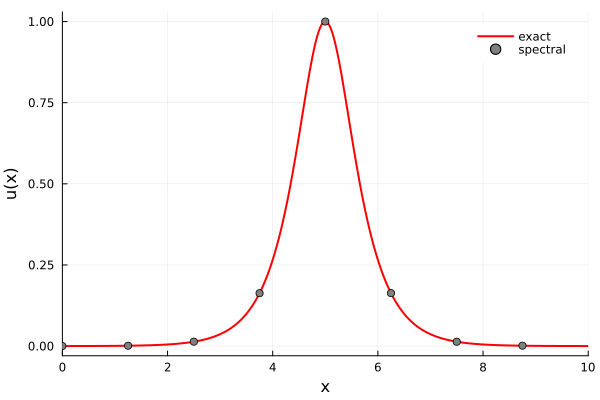

In [3]:
L    = 10.0
nx   = 8
a    = 1.0
ntflow = 1            # flow-through times; result looks perfect for ntflow integer for any nx
                      # but requires more points to look good for non-integer ntflow
tend = ntflow*L/a

#---------- solution domain, initial condition

dx = L/nx     # not L/(nx-1)
x  = LinRange(0.0, L-dx, nx)
u0 = 1.0./(cosh.(2.0*(x .-5.0)))

#---------- exact solution with more points for plotting

xx  = LinRange(0.0, L, 1000)
uu  = 1.0./(cosh.(2.0*(xx .-5.0)))

#---------- solve the problem and plot

function rhsf(u, p, t)
    N = length(u)
    n = collect(0:N-1); n[Int64(floor(N/2))+2:end] .-= N
    return -a*real.(ifft(2*pi*im*n/L.*fft(u)))
end

tspan = [0,tend]
odeprob = ODEProblem(rhsf, u0, tspan)
sol = solve(odeprob)
u = sol.u

plot(xx, uu, color="red", lw=2, label="exact")
scatter!(x,u[end], color="gray", label="spectral")
plot!(legend_foreground_color=nothing)
plot!(xlabel="x", ylabel="u(x)")
plot!(xlim=[0,10])

### Example 2

Solve the viscous Burgers' equation:
$$\frac{\partial u}{\partial t} = -u\frac{\partial u}{\partial x} + \nu\frac{\partial^2u}{\partial x^2}.$$
Here, $\nu$ is viscosity. This equation is nonlinear.
- Use a periodic initial condition of $u_0(x) = \cos(2\pi x/L)+2$.
- $\nu=0.1$
- $L=10$
- Solve to $t=10$.


#### Exact solution
The exact solution ([from wikipedia](https://en.wikipedia.org/wiki/Burgers%27_equation)) is given by
$$u(x,t) = -2\nu\frac{\partial}{\partial x}\ln\left\{(4\pi\nu t)^{-1/2}\int_{-\infty}^\infty\exp\left[-\frac{(x-x^\prime)^2}{4\nu t}-\frac{1}{2\nu}\int_0^{x^\prime}u_0(x^{\prime\prime})dx^{\prime\prime}\right]dx^\prime\right\}.$$
This equation is evaluated here using Sympy.

See also [this link](https://www.azimuthproject.org/azimuth/show/Burgers%27+equation)

In [4]:
function eval_ue(x)
    L = 10.0
    t = 10.0
    ν = 0.1
    n = quadgk(xp->(x-xp)*exp(-L/(4*π*ν)*sin(2*π*xp/L)-xp/ν-(x-xp)^2/(4*t*ν)), -Inf,Inf)[1] 
    d = t*quadgk(xp->exp(-L/(4*π*ν)*sin(2*π*xp/L)-xp/ν-(x-xp)^2/(4*t*ν)),      -Inf,Inf)[1]
    return n/d
end

xe = LinRange(0.,10.,100)
ue = eval_ue.(xe);

#### Spectral solution
$$\frac{du_j}{dt} = -uF^{-1}\left(\frac{2\pi in}{L}F(u_j)\right) + 
\nu F^{-1}\left(\left(\frac{2\pi i n}{L}\right)^2F(u_j)\right),$$


In [5]:
function spectral(nx)
    L    = 10.0
    ν    = 0.1          # use same value as the exact solution above
    tend = 10.          # use same value as the exact solution above
    
    #---------- solution domain, initial condition
    
    dx = L/nx     # not L/(nx-1)
    x = LinRange(0.0, L-dx, nx)
    u0 = cos.(2*pi*x/L) .+ 2
    
    #---------- solve the problem
    
    function rhsf(u, p, t)
        N = length(u)
        n = collect(0:N-1); n[Int64(floor(N/2))+2:end] .-= N
        return -u.*real.(ifft(2*pi*im*n/L.*fft(u))) .- ν*real.(ifft((2*pi*n/L).^2 .*fft(u)))
    end
    
    tspan = [0,tend]
    odeprob = ODEProblem(rhsf, u0, tspan)
    sol = solve(odeprob, abstol = 1e-10, reltol = 1e-10)
    u = sol.u
    t = sol.t
    
    return x, t, u
end;

#### Plot results

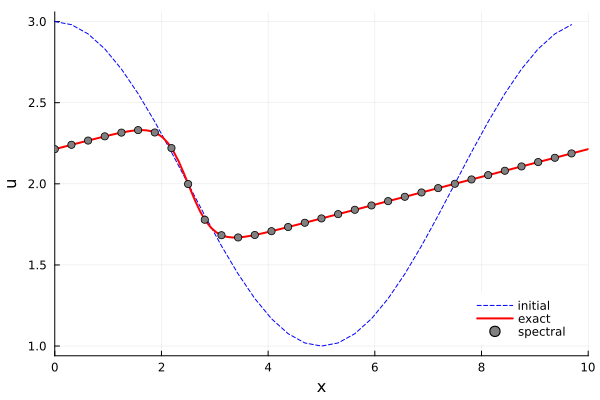

In [6]:
function make_plot1()
    x, t, u = spectral(32)
    u0 = u[1]
    
    plot(x,u0, linestyle=:dash, color="blue", lw=1, label="initial")
    plot!(xe,ue, color="red", lw=2, label = "exact")
    scatter!(x,u[end], color="gray", lw=1, label="spectral")
    plot!(legend_foreground_color=nothing)
    plot!(xlabel="x", ylabel="u", xlim=[0,10])
end
make_plot1()

### Finite difference solver

In [7]:
function FD(nx)
    L    = 10.0
    ν    = 0.1           # use same value as the exact solution above
    tend = 10.0          # use same value as the exact solution above
    
    #---------- solution domain, initial condition
    
    dx = L/nx     # not L/(nx-1)
    x = LinRange(0.0, L-dx, nx)
    u0 = cos.(2*pi*x/L) .+ 2
    
    #---------- solve the problem
    
    i  = collect(1:nx)
    ip = i.+1; ip[end] = 1
    im = i.-1; im[1]   = nx
    
    function rhsf(u, p, t)
        #return -u.*(u .- u[im])/dx .+ ν/dx/dx*(u[im] .- 2*u .+ u[ip])        # upwind on the advective term: 1st order
        return -u.*(u[ip] .- u[im])/2/dx .+ ν/dx/dx*(u[im] .- 2*u .+ u[ip])   # central difference: 2nd order
    end
    
    tspan = [0,tend]
    odeprob = ODEProblem(rhsf, u0, tspan)
    sol = solve(odeprob, abstol = 1e-10, reltol = 1e-10)
    u = sol.u
    t = sol.t
    
    return x, t, u
end;


### Compare spectral and finite difference on multiple grids
* The spectral method bottoms out at $\le$ 80 points, where the average error is 0.4$\times 10^6$ times less than the second order finite difference method.
* For an average relative error of around 4$\times 10^6$, the spectral method requires around 13 times fewer grid points (40 versus 512).

In [8]:
nxs = [2,4,6,8,10,14,20,30,45,60,80,128,256,512]
errSP = zeros(length(nxs))
errFD = zeros(length(nxs))

for (i,nx) in enumerate(nxs)
    println("i=$i, nx=$nx")
    x,t,usp = spectral(nx)
    x,t,ufd = FD(nx)
    usp = usp[end]
    ufd = ufd[end]
    ue  = eval_ue.(x)
    errSP[i] = norm((usp.-ue)./ue)/nx
    errFD[i] = norm((ufd.-ue)./ue)/nx
end

i=1, nx=2
i=2, nx=4
i=3, nx=6
i=4, nx=8
i=5, nx=10
i=6, nx=14
i=7, nx=20
i=8, nx=30
i=9, nx=45
i=10, nx=60
i=11, nx=80
i=12, nx=128
i=13, nx=256
i=14, nx=512


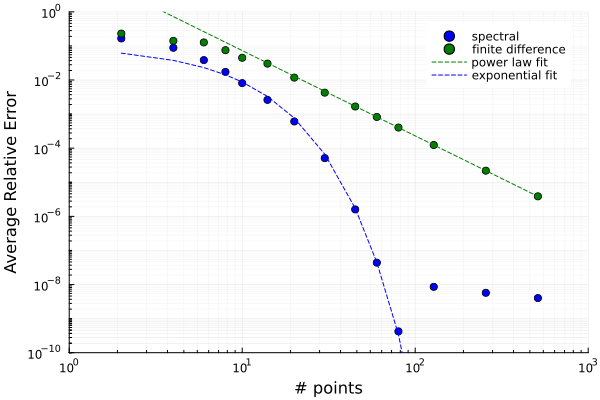

In [9]:
#---------- Spectral, and show exponential convergence: fit err=a*exp(b*nx)

scatter(nxs,errSP,  xscale=:log10, yscale=:log10, color="blue", label="spectral", size=(600,400))
scatter!(nxs,errFD, xscale=:log10, yscale=:log10, color="green", label="finite difference")
plot!(ylim=[1E-10,1], xlim=[1,1000])
plot!(xlabel="# points", ylabel="Average Relative Error")
plot!(legend_foreground_color=nothing)
yticks!([1E-10, 1E-8, 1E-6, 1E-4, 1E-2, 1E0])
plot!(minorticks=10, minorgrid=true)

#-------- linear fit to FD data: RE = an^b
fitL = Polynomial(poly_fit(log.(nxs[end-4:end]), log.(errFD[end-4:end]), 1))
plot!(nxs, exp.(fitL.(log.(nxs))), label="power law fit", color="green", ls=:dash)

#-------- exponential fit to Spectral data: RE = ae^{bn}

fitE = Polynomial(poly_fit(nxs[3:11], log.(errSP[3:11]), 1))
plot!(nxs, exp.(fitE.(nxs)), label="exponential fit", color="blue", ls=:dash)